## Precision-weighted attention

### Setup

In [1]:
import numpy as np
import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=20)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader

import os
import argparse
import time
from tqdm import tqdm # Loading bar

In [2]:
from utils import complex_conj_transpose, batched_complex_conj_transpose, complex_exp, complex_exp_v2, complex_hadamard, complex_matmul, complex_division
from utils import batched_complex_conj_transpose, batched_complex_hadamard, batched_complex_matmul, batched_complex_division
from utils import batched_complex_exp, batched_complex_hadamard_full, batched_complex_matmul_full
print('Done.')

Done.


In [3]:
# from misc import f_pij_scalar
# from misc import construct_2D_rotation_matrix, construct_2D_unitary_matrix, construct_special_2D_unitary, construct_diag_matrix, construct_2D_normal_matrix, orthogonal_matrix_2D
# print('Done')

In [4]:
from dynamics import stochastic_LTI, DynamicSim
from dynamics import construct_mapping
from dynamics import get_nth_measurement, get_random_measurements
from dynamics import linear_spiral, linear_spiral_3D, Lorenz, rand_coupling_matrix, Van_der_Pol_osc
print('Done.')

Done.


In [5]:
from precision_attention import compute_residuals, compute_kernel_v1, compute_estimates_and_residuals_vectorized, get_time_diffs, compute_neg_kernel, clamp_exponent_arg
from precision_attention import compute_kernel, batched_compute_estimates_and_residuals_vectorized, compute_estimates_and_residuals_irregular_times, compute_nu
from precision_attention import compute_precision_v1
# from precision_attention import precise_attn, precise_attn_with_correction, precise_attn_full
from precision_attention import compute_precision, compute_precision_tanh
print('Done.')

Done.


In [6]:
from model import compute_lambda_h
from model import init_complex_matrix, build_nearly_identity, initialize_to_correct_model
from model import init_weight_masks, apply_weight_masks
from model import Complex_MSE_Loss, Batched_Complex_MSE_Loss, inverse_penalty
from model import BatchedPrecisionAttentionBlock
from model import HadamardLayer, TemporalNorm, TemporalWhiteningLayer
from model import PrecisionNet_1layer, PrecisionNet
print('Done.')

Done.


In [7]:
from data_utils import construct_random_mapping, construct_data, TrainDataset, create_train_loader
print('Done.')

Done.


In [8]:
from visualization import plot_trajectory, compute_state_transition_matrix, plot_state_transition_matrix, plot_eigenvals, visualize_results
print('Done.')

Done.


In [9]:
from training import single_iter, single_epoch, hook_fn
print('Done.')

Done.


In [10]:
parser = argparse.ArgumentParser('DA')
parser.add_argument('--gpu', type=int, default=0) # (Default: 0)
args = parser.parse_args(args=[])
args.device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
print(args.device)

torch.manual_seed(2025)
np.random.seed(2025)

cuda:0


### Training

In [11]:
# Set dynamical system

# # Normal system
# D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
# D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
# D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
# # S1 = torch.zeros(2,2,2).to(args.device)
# # S1[0] = torch.tensor(([1.0,1.0],[0.0,0.0]))
# # S1[1] = torch.tensor(([0.0,0.0],[1.0,-1.0]))
# # S1 = U/np.sqrt(2)
# alpha = np.random.uniform(low=0.0, high=1.0)*2*np.pi
# beta = np.random.uniform(low=0.0, high=1.0)*2*np.pi
# S1 = construct_special_2D_unitary(alpha=alpha, beta=beta)
# Si1 = complex_conj_transpose(S1)

# Stable 2D linear system (in diagonalized form):
D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
S1 = torch.zeros(2,2,2).to(args.device) # RHS matrix
Si1 = torch.zeros(2,2,2).to(args.device) # Inverse of RHS matrix
D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
# D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.5]]).to(args.device)
# D1[1] = torch.tensor([[-0.0, 0.0], [0.0, 0.0]]).to(args.device)
S1[0] = torch.tensor([[1.0, 1.0], [1.0, 1.0]]).to(args.device)
S1[1] = torch.tensor([[-1.0, 1.0], [0.0, 0.0]]).to(args.device)
Si1[0] = 0.5*torch.tensor([[0.0, 1.0], [0.0, 1.0]]).to(args.device)
Si1[1] = 0.5*torch.tensor([[1.0, -1.0], [-1.0, 1.0]]).to(args.device)
A = complex_matmul(S1,complex_matmul(D1,Si1))[0].unsqueeze(0)
params = [D1, S1, Si1]

In [12]:
# DEFINE MODEL

args.cr_max = 2
args.cr_min = 0

args.t_equal = 1 # Equal time intervals? (0 or 1)

args.m = 2 # Dimension of simulated system
# args.embed_dim = 2 # Embedding dimension
args.embed_dim = 256 # Embedding dimension

args.num_heads = 1
args.head_dim = int(args.embed_dim/args.num_heads)

#######################################

# Key, query, value embedding dimensions are same as input embedding dimension
args.d_k = args.head_dim
args.d_v = args.head_dim

# # Key, query, value embedding dimensions are half of input embedding dimension
# args.d_k = int(args.head_dim/2) # Key and query embedding dimension
# args.d_v = int(args.head_dim/2) # Value embedding dimension

# # Key, query, value embedding dimensions are 2
# args.d_k = 2 # Key and query embedding dimension
# args.d_v = 2 # Value embedding dimension

#######################################

args.nu = 1.0 # Measurement weighting
args.tf = 10.0 # Final time
args.dt = 0.01 # Time step size
args.n = 10 # nth measurement (ie use every nth point as a measurement)

args.N_t = int(args.tf/args.dt) # Number of time steps
args.seq_len = int(args.N_t/args.n) # Number of measurements
# t_v = (torch.arange(args.N_t + args.n)*args.dt).to(args.device) # Array of time steps
t_v = (torch.arange(args.N_t + args.n)*args.dt).to(args.device) # Array of time steps

# Some scalar weights in model
args.alpha = 1.0
args.beta = 0.0
args.delta = 1.0
args.eta = 0.0

# model = PrecisionAttentionBlock(args).to(args.device)
model = PrecisionNet_1layer(args).to(args.device) # Define model
params_list = list(model.parameters()) # Parameters list

Pu, Pd, R1, R1i = construct_random_mapping(S1, Si1, args) # Get random matrices

loss = Batched_Complex_MSE_Loss() # Loss
loss_p = Complex_MSE_Loss() # Frobenius Norm Penalty
# loss_p = Complex_Trace_Loss() # Trace Penalty
lr = 1E-2 # Learning rate
optimizer = torch.optim.Adam(params_list, lr=lr, betas=(0.9, 0.999)) # Optimizer

Training progress...:   0%|▏                                                          | 3/1000 [00:00<04:27,  3.73it/s]

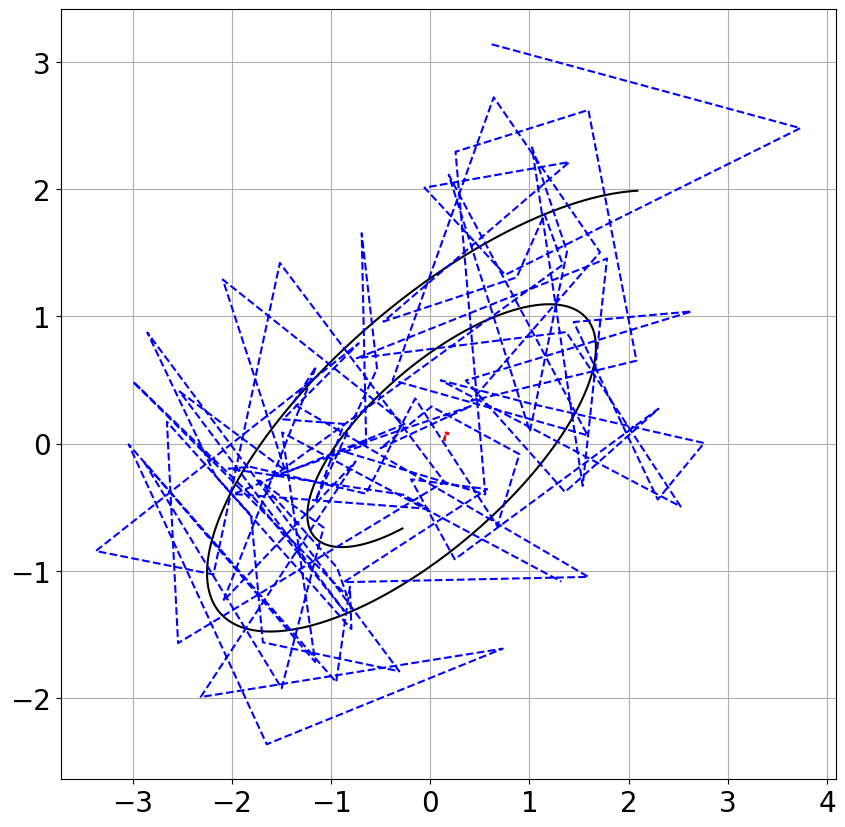

C:\Users\Pracioppo\Desktop\Peter DynAttn Proj\visualization\visualization.py:209: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.scatter(xi.T[0],xi.T[1], s=100, marker='x', color=colors[np.mod(mi,len(colors))])


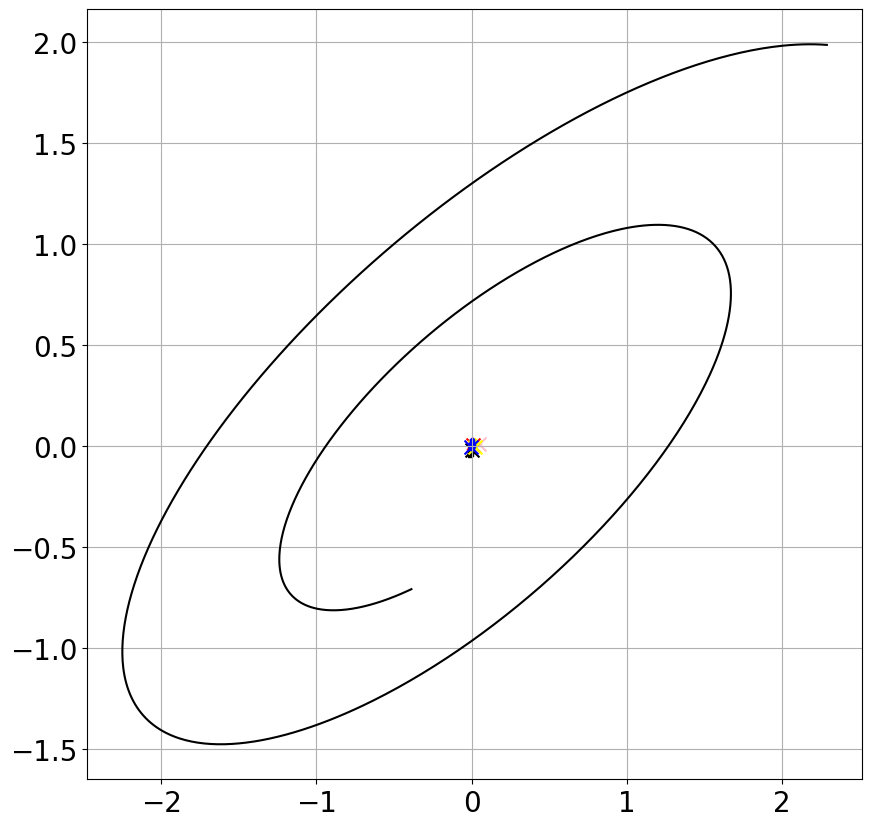

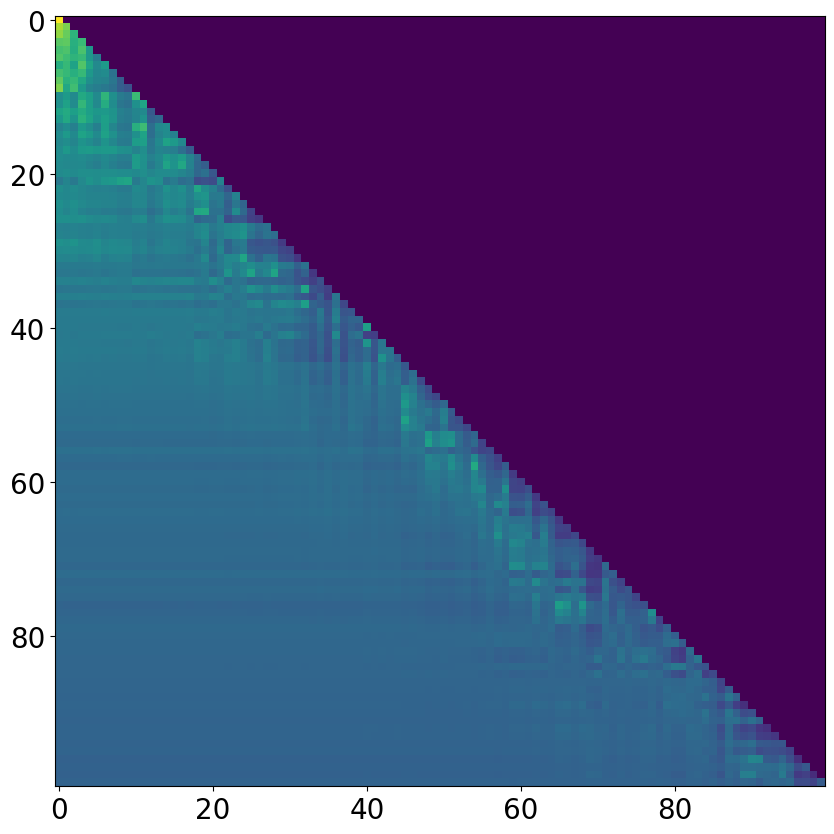

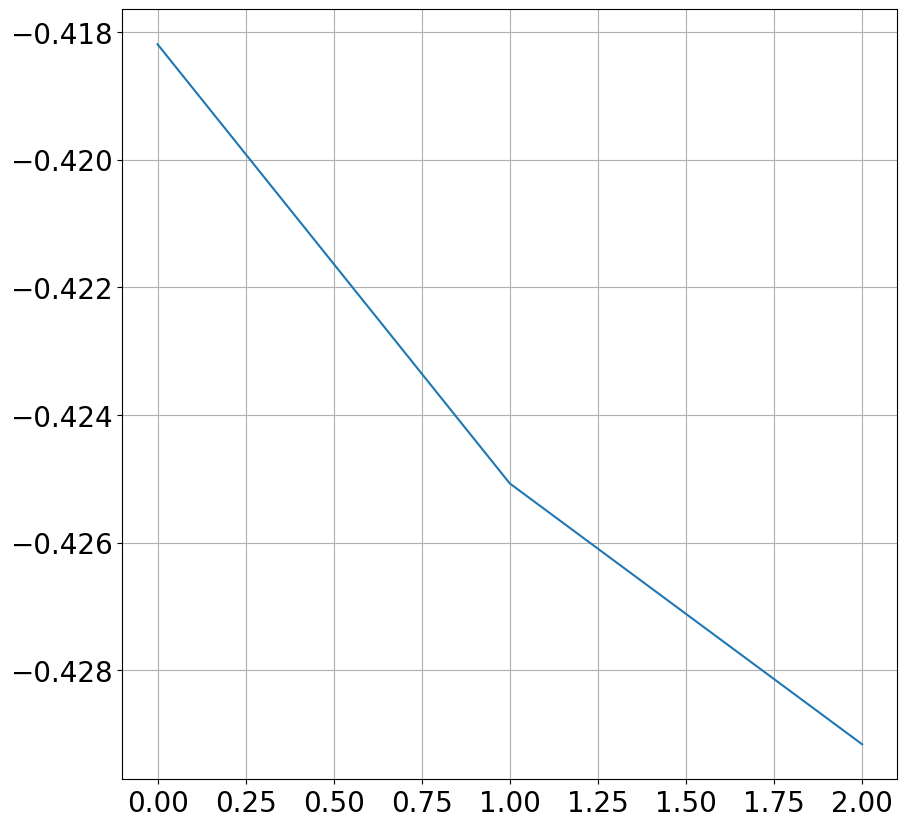

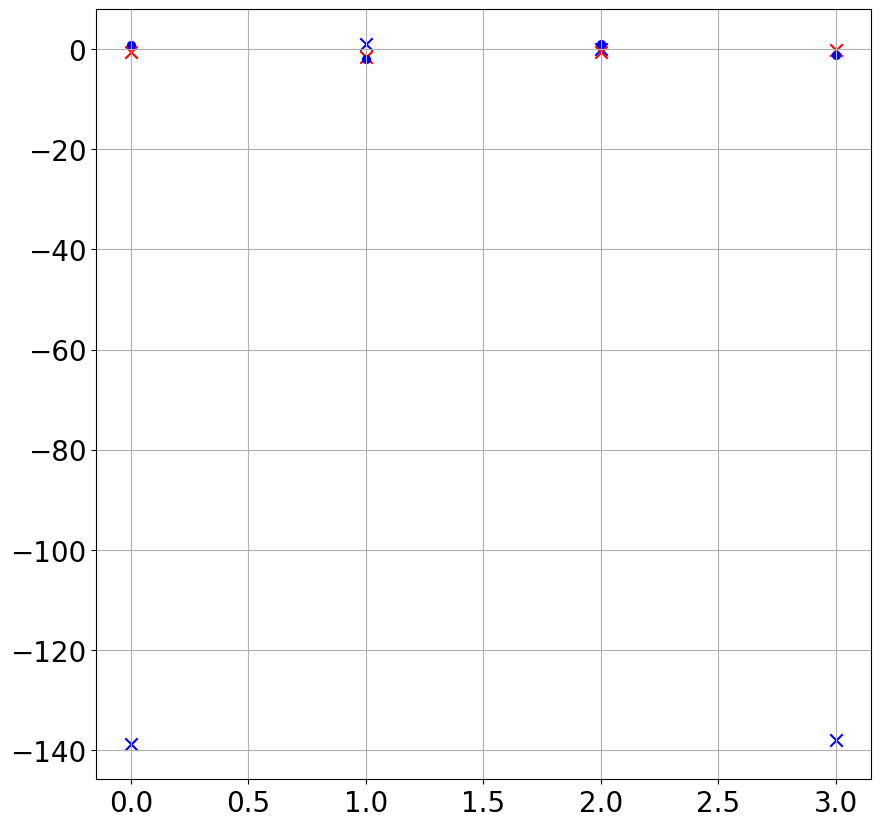

Training progress...:   0%|▏                                                          | 4/1000 [00:02<10:18,  1.61it/s]

tensor([-1.1235,  1.7537], device='cuda:0')
tensor([[0.6036, 0.0278],
        [0.0344, 0.5895]])


Training progress...:   1%|▍                                                          | 7/1000 [00:02<05:28,  3.02it/s]

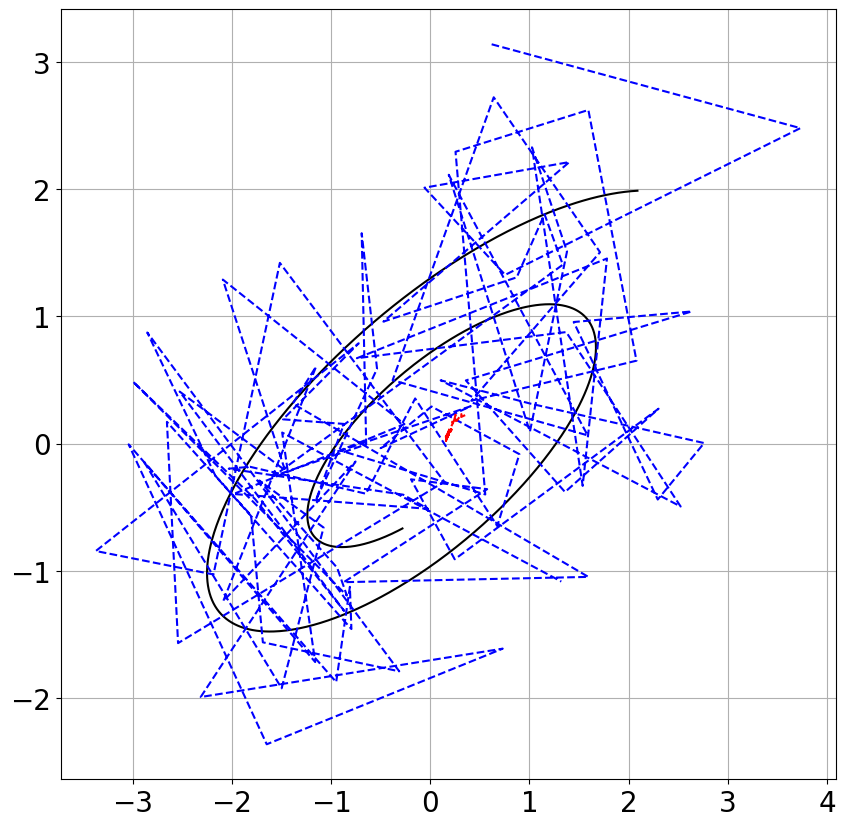

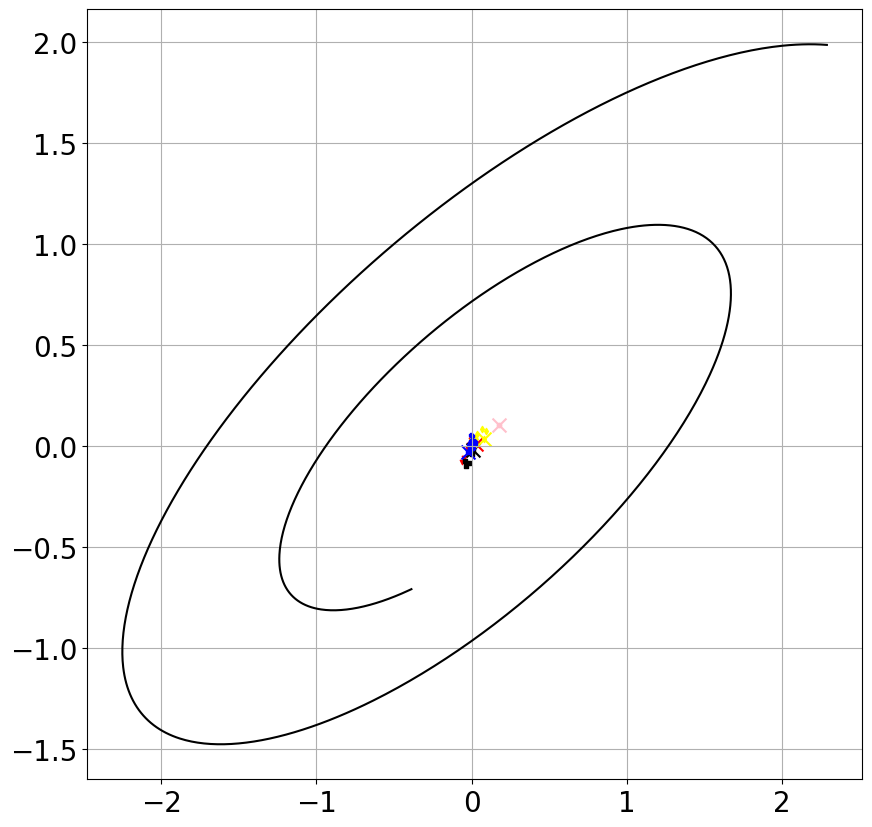

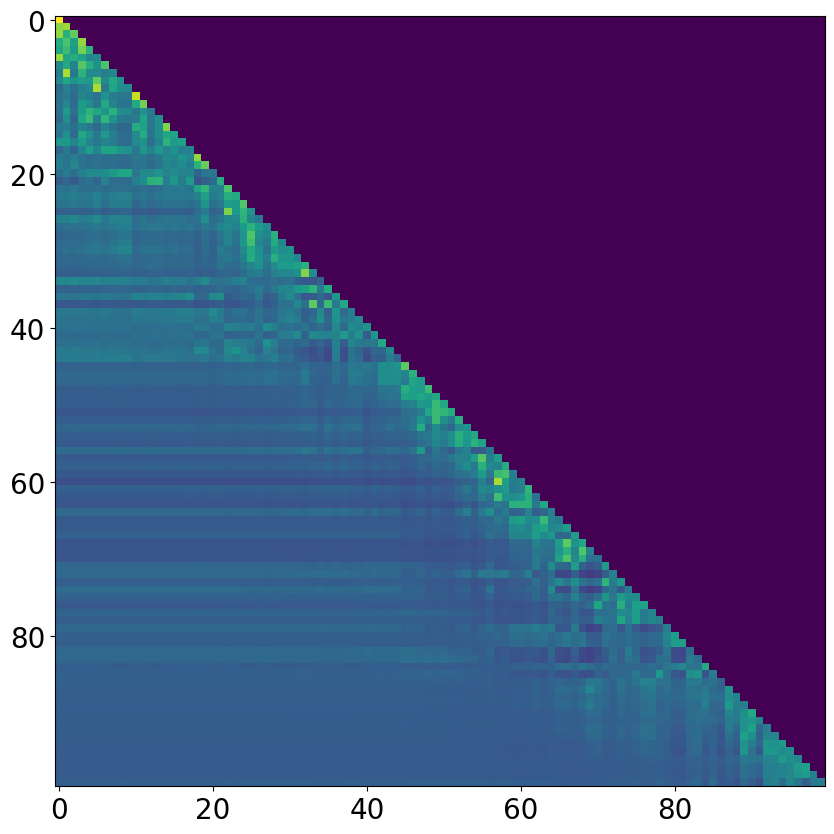

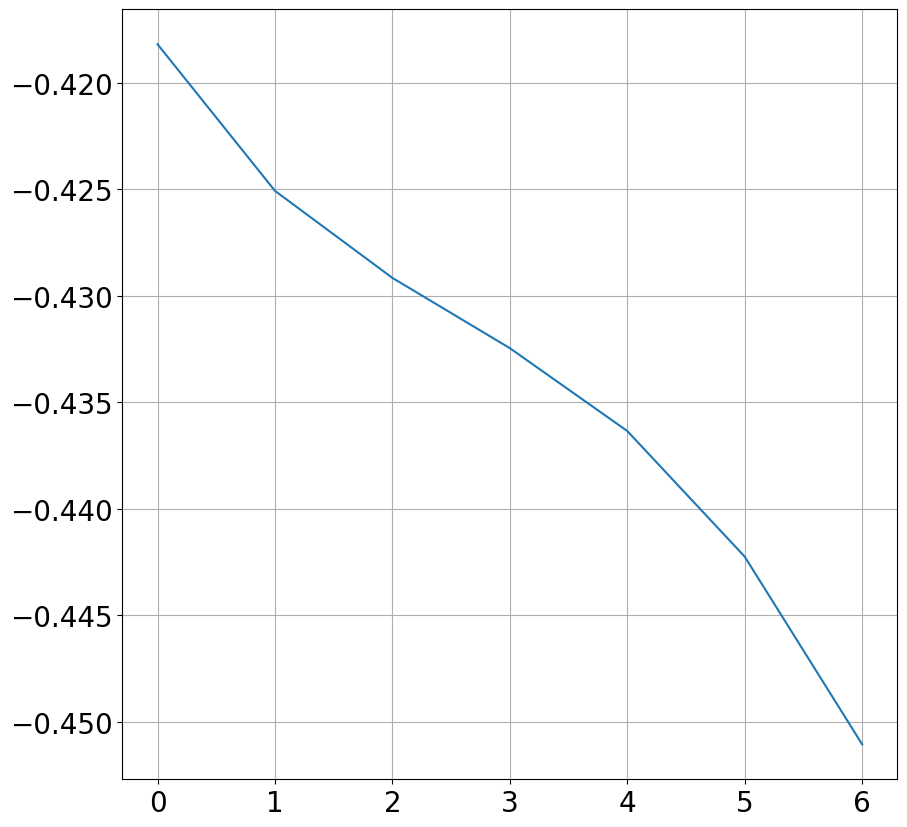

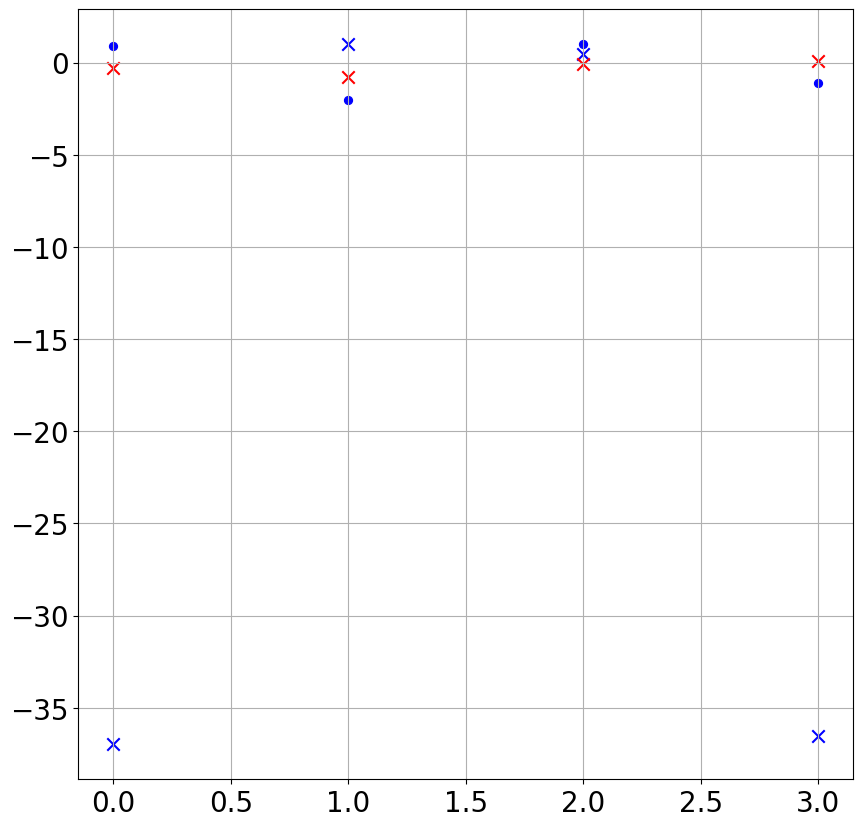

Training progress...:   1%|▍                                                          | 8/1000 [00:03<09:18,  1.78it/s]

tensor([-1.0865,  1.7931], device='cuda:0')
tensor([[0.8900, 0.0482],
        [0.0182, 0.8669]])


Training progress...:   1%|▋                                                         | 11/1000 [00:04<05:36,  2.94it/s]

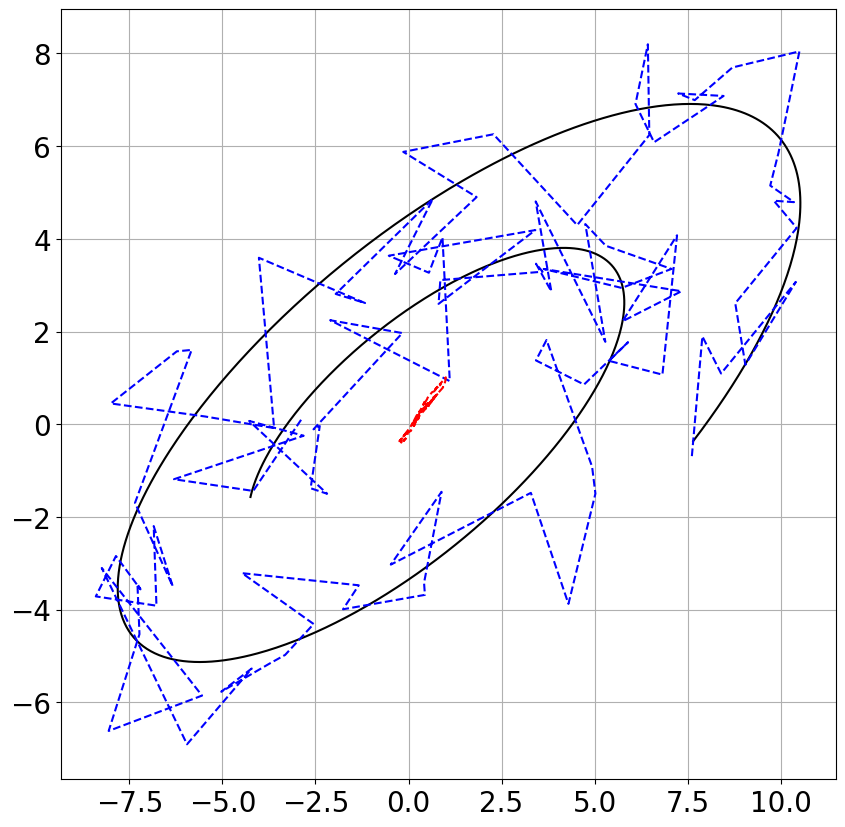

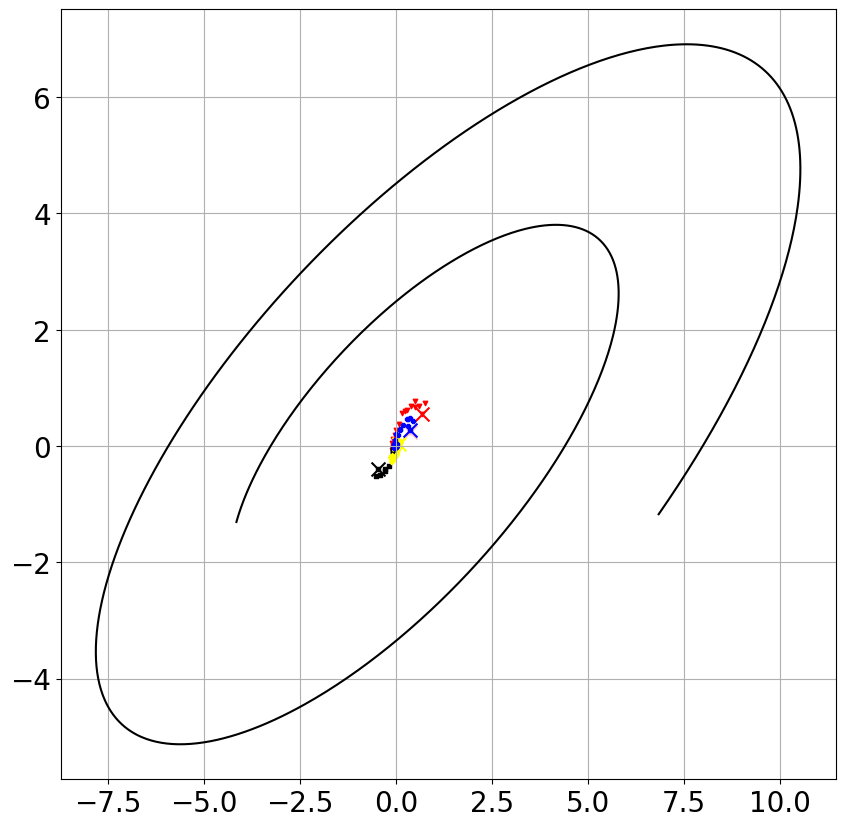

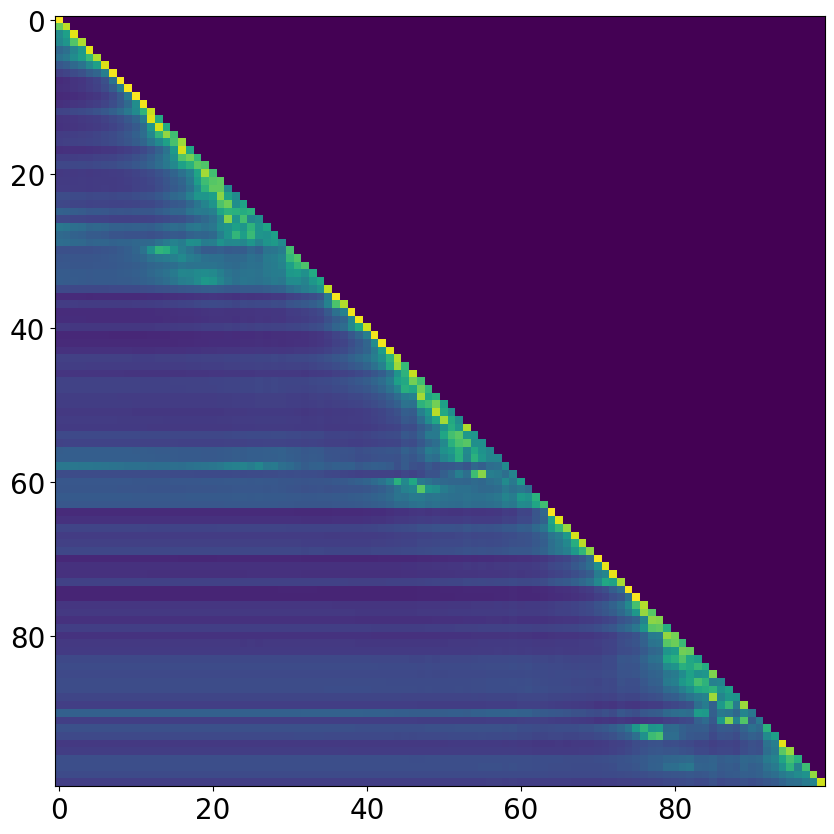

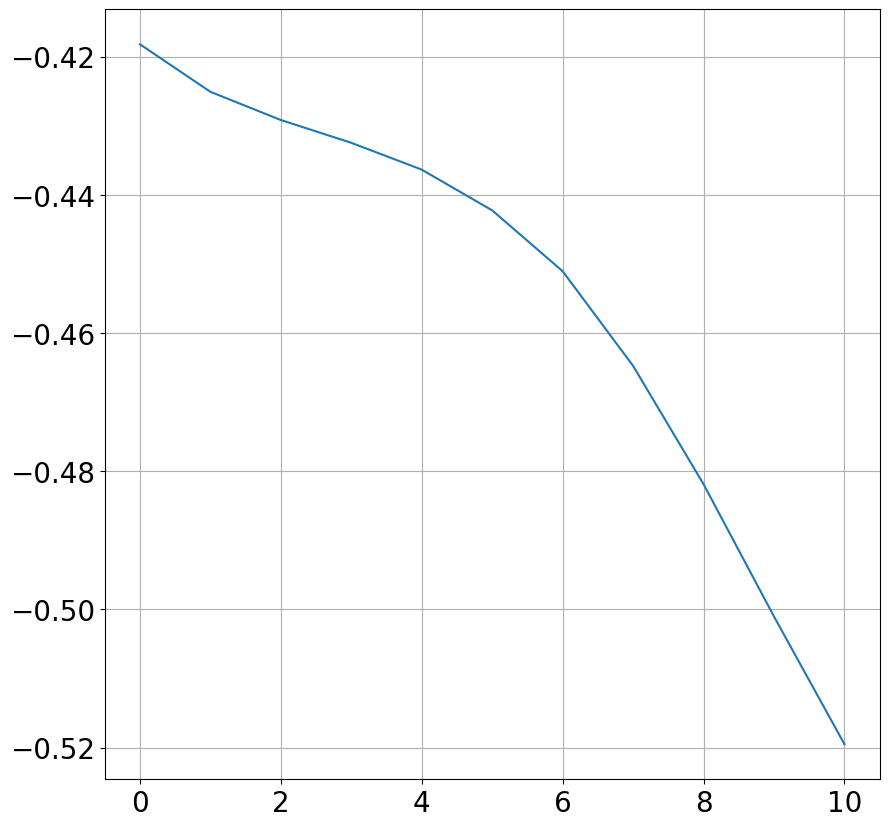

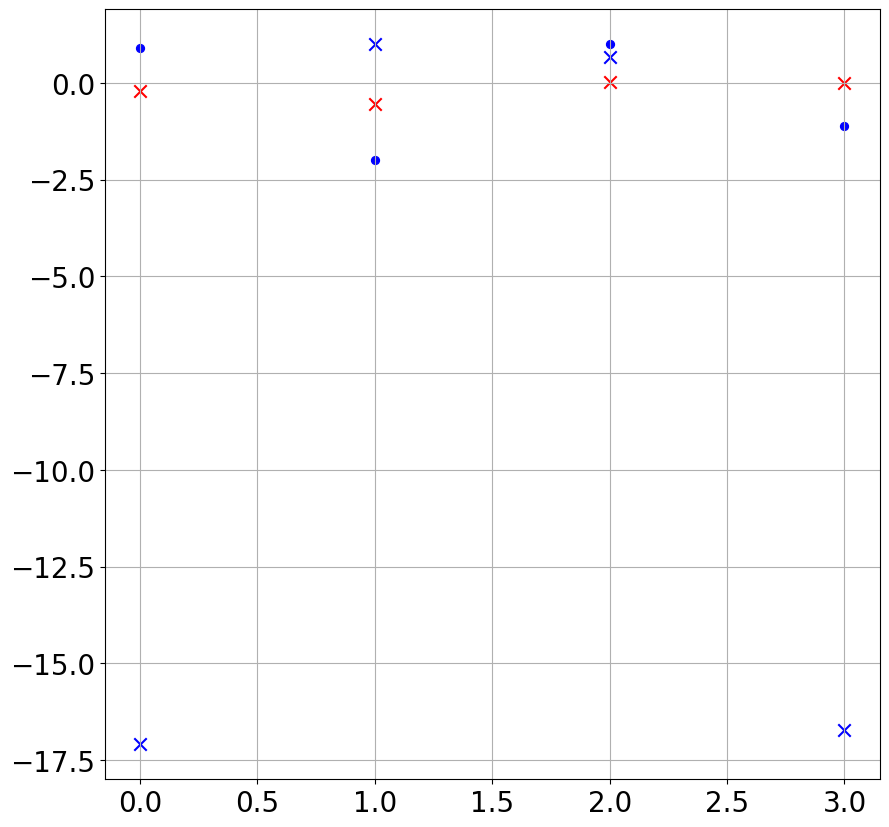

Training progress...:   1%|▋                                                         | 12/1000 [00:05<09:10,  1.79it/s]

tensor([-1.0472,  1.8333], device='cuda:0')
tensor([[9.5635e-01, 5.7860e-02],
        [2.9720e-04, 9.3857e-01]])


Training progress...:   2%|▊                                                         | 15/1000 [00:06<05:28,  2.99it/s]

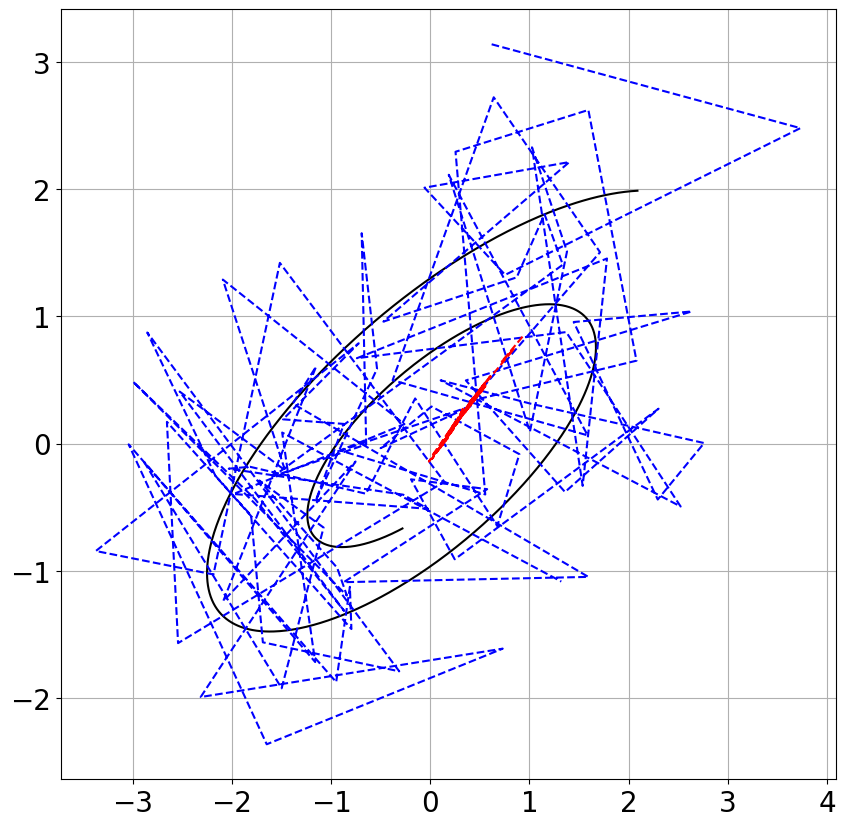

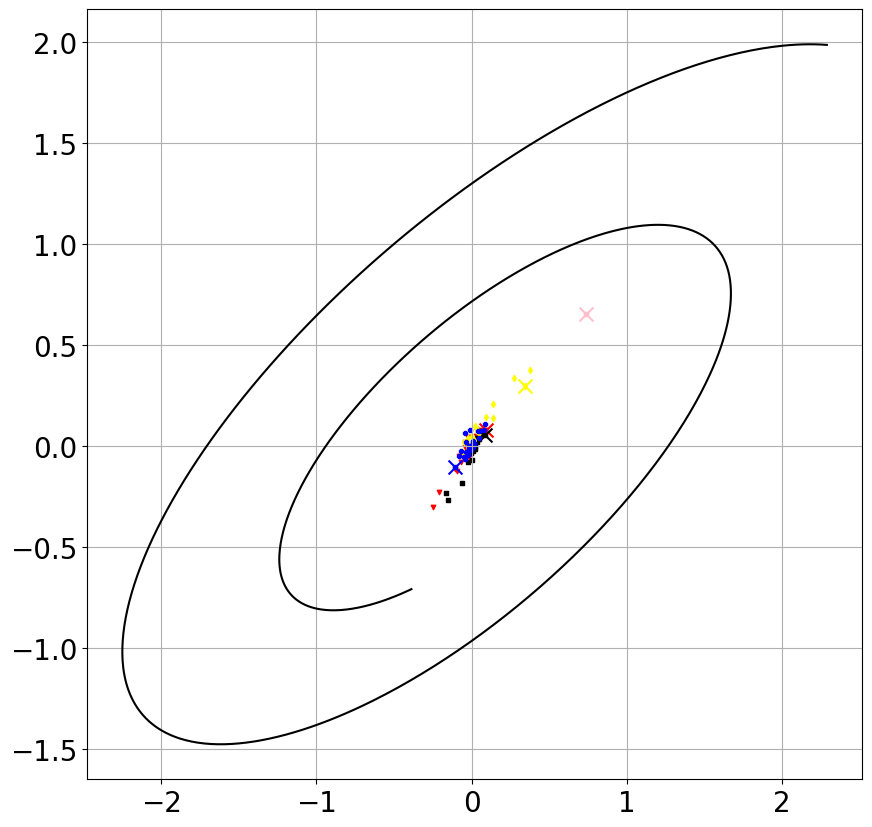

Training progress...:   2%|▊                                                         | 15/1000 [00:06<07:28,  2.20it/s]


KeyboardInterrupt: 

In [13]:
########################### TRAINING LOOP ###########################
#####################################################################

args.num_epochs = 1000 # Number of epochs
args.num_samp = 32 # Number of samples in train loader
args.batch_size = 32 # Batch size
args.num_its = int(args.num_samp/args.batch_size) # Number of iterations in an epoch
args.save_epochs = 1 # Intervals of epochs to save model
args.show_example_epochs = 4 # Number of epochs between displaying results so far
args.n_example = 5 # Plot state estimates at n_example data points

# args.penalty_weight = 0.1 # Penalty weight
args.penalty_weight = 1.0 # Penalty weight
args.weight_mask = 1 # Mask the weights? (0 or 1)
args.tanh = 0 # Use tanh precision? (0 or 1)
args.nu_adaptive = 0 # Use adaptive calculation of nu? (0 or 1)

mean_epoch_losses = np.zeros(args.num_epochs)
log_mean_epoch_losses = np.zeros(args.num_epochs)
all_losses = np.zeros(args.num_epochs * args.num_samp)
all_lambdas = np.zeros((args.num_epochs, 2, args.d_v))

sigma_process = 0.0 # Process noise
# sigma_process = 0.2 # Process noise
sigma_process_0 = sigma_process # Initial process noise
# sigma_measure = 0.1 # Measurement noise
sigma_measure = 1.0 # Measurement noise

# Build training dataset
train_loader, train_dataset, X_true_all, X_measure_all, t_measure_all = create_train_loader(A, S1, Si1, Pu, Pd, R1, R1i, t_v, sigma_process, sigma_process_0, sigma_measure,args)

# # Initialize to correct values (for testing)
# initialize_to_correct_model(model.a1, D1, S1, Si1, sigma_process, sigma_process_0, sigma_measure, args)

# Train for num_epochs:
for epoch in tqdm(np.arange(args.num_epochs), desc="Training progress..."):

#     # Get training data online:
#     train_loader, train_dataset, X_true_all, X_measure_all, t_measure = create_train_loader(A, S1, Si1, Pu, Pd, R1, R1i, t_v, sigma_process, sigma_process_0, sigma_measure,args)

    # Train for single epoch
    epoch_losses, Q_ij, epoch_lambdas = single_epoch(model, train_loader, optimizer, loss, loss_p, params_list, args)
    
    # Collect losses
    all_losses[epoch*args.num_its:(epoch+1)*args.num_its] = epoch_losses
    mean_epoch_losses[epoch] = np.mean(epoch_losses)
    log_mean_epoch_losses[epoch] = np.log(np.mean(epoch_losses))
    all_lambdas[epoch,:,:] = np.mean(epoch_lambdas,axis=0)
    
    # Visualize results so far:
    if np.mod(epoch+1,args.show_example_epochs) == 0:
        visualize_results(model, model.a1, train_dataset, all_losses, mean_epoch_losses, log_mean_epoch_losses, all_lambdas, R1, R1i, Pu, Pd, A, epoch, args)